In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()
%matplotlib inline

np.random.seed(3)

https://www.kaggle.com/code/diegovicente/using-shap-values-for-interpretability

https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial

In [2]:
all_TGTGC=pd.read_csv('/home/jiayi/5moU/data/DL_fromTombo/all_TGTGC.csv')
all_TGTGC

,indx,kmer,mean_1,mean_2,mean_3,mean_4,mean_5,std_1,std_2,std_3,...,mdintense_2,mdintense_3,mdintense_4,mdintense_5,L-1,L-2,L-3,L-4,L-5,label
0,239,TGTGC,-0.393038,0.108138,-0.113532,0.249268,-0.086032,0.161574,0.160491,0.073126,...,0.129871,-0.119397,0.330961,-0.123587,107,16,45,12,84,1
1,1169,TGTGC,0.577563,0.486387,-0.108924,-0.400086,-0.315799,0.066415,0.151296,0.282783,...,0.580229,-0.108924,-0.400086,-0.320487,11,5,2,2,42,1
2,179,TGTGC,0.187476,0.160928,-0.234632,0.034336,-0.355640,0.073017,0.150002,0.170773,...,0.162808,-0.207210,-0.014801,-0.353103,6,27,130,92,205,1
3,629,TGTGC,0.135409,-0.110499,-0.142222,0.176287,-0.148357,0.162376,0.035083,0.068957,...,-0.101557,-0.132215,0.229940,-0.183952,12,6,18,7,2952,1
4,135,TGTGC,-0.328761,-0.313913,-0.315879,-0.368903,-0.261595,0.019089,0.004242,0.065705,...,-0.313913,-0.313913,-0.356334,-0.246040,2,2,41,27,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834,84,TGTGC,0.206723,0.212892,-0.338564,-0.329485,-0.370310,0.072448,0.178362,0.169781,...,0.160701,-0.337245,-0.316874,-0.364406,6,17,151,14,46,0
13835,12,TGTGC,-0.224099,-0.016030,-0.042468,0.269796,-0.131406,0.062839,0.149749,0.070616,...,-0.024357,-0.052460,0.326003,-0.114289,187,9,6,22,44,0
13836,942,TGTGC,0.186421,0.073605,-0.127920,0.148950,-0.254331,0.138621,0.517487,0.105292,...,-0.091806,-0.118036,0.194853,-0.237945,24,7,127,12,59,0
13837,262,TGTGC,-0.142096,-0.245403,-0.296681,-0.177880,-0.429734,0.295662,0.047933,0.116175,...,-0.251280,-0.295365,-0.178541,-0.440843,73,6,67,20,125,0


In [3]:
kfolds = KFold(n_splits=5, shuffle=True)
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.2,
    'silent': 1,
    'nthreads': 2,
}

num_round = 10

thres = 0.5

In [4]:
features = ['mean_1', 'mean_2', 'mean_3', 'mean_4', 'mean_5',
        'std_1', 'std_2', 'std_3', 'std_4', 'std_5', 'mdintense_1',
        'mdintense_2', 'mdintense_3', 'mdintense_4', 'mdintense_5', 'L-1',
        'L-2', 'L-3', 'L-4', 'L-5']
target = 'label'

#X = dataset[features]
X=all_TGTGC.iloc[:,2:all_TGTGC.shape[1]-1]
y = all_TGTGC[target]

In [5]:
cnf = list()
auc = list()

for train_idx, test_idx in kfolds.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    param['scale_pos_weight'] = (y_train.size - y_train.sum()) / y_train.sum()    
    
    xg_train = xgb.DMatrix(
        X_train.values, feature_names=features, label=y_train.values
    )
    xg_test = xgb.DMatrix(
        X_test.values, feature_names=features, label=y_test.values
    )
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round, watchlist, verbose_eval=False)
    preds = bst.predict(xg_test)
    
    cnf.append(confusion_matrix(y_test, (preds > thres).astype(int)))
    auc.append(roc_auc_score(y_test, preds))
    
cnf = sum(cnf)
auc = sum(auc) / len(auc)

'Average AUC: {:.04f}'.format(auc)    

Pass `evals` as keyword args.


[12:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.



Pass `evals` as keyword args.
Pass `evals` as keyword args.


[12:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[12:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.



Pass `evals` as keyword args.
Pass `evals` as keyword args.


[12:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

[12:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.



'Average AUC: 0.9454'

Text(58.222222222222214, 0.5, 'Observation')

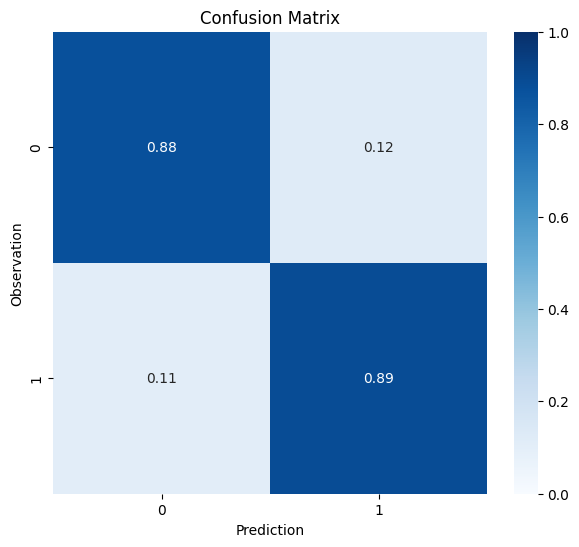

In [6]:
fig, ax = plt.subplots(figsize=(7, 6))

normalized_cnf = cnf / cnf.sum(axis=1).reshape(-1, 1)

sns.heatmap(normalized_cnf, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=1)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


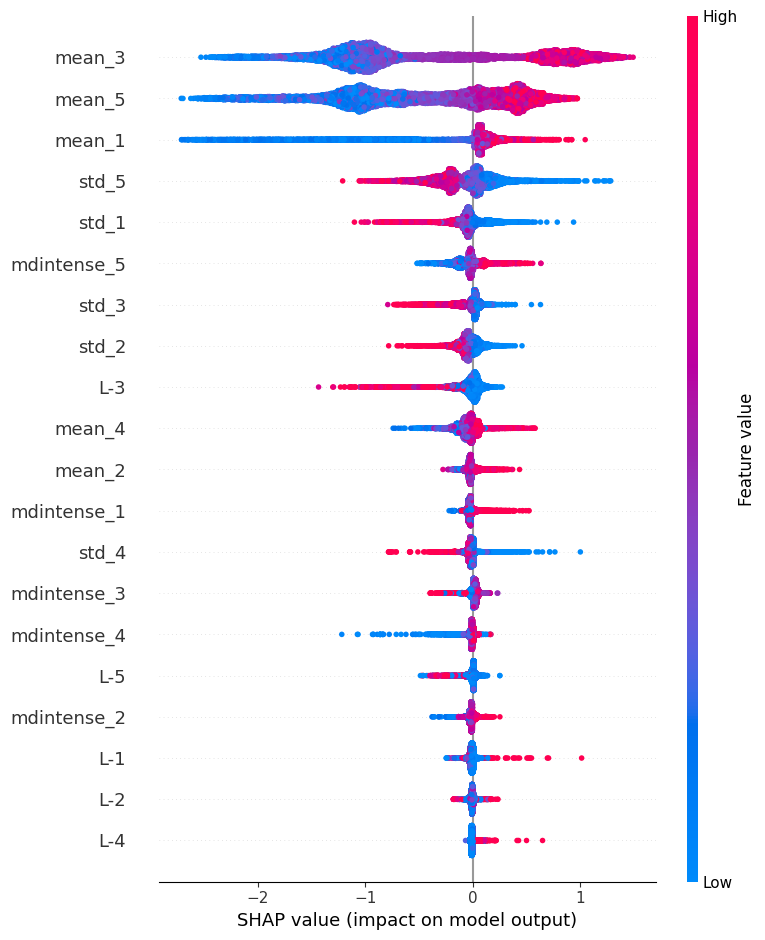

In [7]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)